In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
! rm -rf data_dir
! rm -rf tes*
! rm -rf tra* 
! rm -rf val*

In [3]:
dataset = "/content/gdrive/MyDrive/Deep Learning/MRI dataset/"
! mkdir data_dir
! cp -r /content/gdrive/MyDrive/Deep\ Learning/MRI\ dataset/* ./data_dir

In [4]:
ROOT_DIR = '/content/data_dir'

In [5]:
import warnings 
warnings.filterwarnings('ignore')

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob

In [7]:
#count the number of imgaes in the respective classes 
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
  number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

In [8]:
number_of_images.items()

dict_items([('no', 98), ('yes', 155)])

We will split the data as:
70% Training 
15% Validation
15% testing

In [9]:
# # Create a training folder 
# if not os.path.exists('./train'):
#   os.mkdir("./train")

#   for dir in os.listdir(ROOT_DIR):
#     os.makedirs('./train/'+dir)

#     for img in np.random.choice(a = os.listdir(os.path.join(ROOT_DIR, dir)), 
#                                 size = math.floor(0.7 * number_of_images[dir])-2,
#                                 replace=False):
#       O= os.path.join(ROOT_DIR,dir,img)
#       D = os.path.join("./train", dir)
#       shutil.copy(O,D)

#       # os.remove(O)
# else:
#   print("Folder exists")

In [10]:
def dataFolder(path, split):
  # Create a training folder 
  if not os.path.exists('./'+path):
    os.mkdir("./"+path)

    for dir in os.listdir(ROOT_DIR):
      os.makedirs('./'+path+'/'+dir)

      for img in np.random.choice(a = os.listdir(os.path.join(ROOT_DIR, dir)), 
                                  size = math.floor(split * number_of_images[dir]) ,
                                  replace=False):
        O= os.path.join(ROOT_DIR,dir,img)
        D = os.path.join("./"+path, dir)
        shutil.copy(O,D)
        os.remove(O)
  else:
    print(path+" Folder exists")

In [11]:
dataFolder('train', 0.7)

In [12]:
dataFolder('val', 0.15)


In [13]:
dataFolder('test', 0.15)

In [14]:
number_of_images.items()

dict_items([('no', 98), ('yes', 155)])

In [16]:
# # Determining input shape using opencv


# image_path= '/content/train/yes/Y10.jpg'
# import cv2 
# image = cv2.imread(image_path)
# print(image.shape)

# Model Build

In [17]:
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D
from keras.models import Sequential
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import keras

In [18]:
#CNN model

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape = (224,224,3)))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(rate=0.25))


model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)       7

In [19]:
model.compile(optimizer='adam', loss= keras.losses.binary_crossentropy, metrics=['accuracy'])

Preparing our data using data generator

In [20]:
def preprocessingimages(path):
  #input : path
  #output : Preprocessed image

  image_data = ImageDataGenerator(zoom_range = 0.2, shear_range= 0.2, rescale = 1/255, horizontal_flip=True)
  image = image_data.flow_from_directory(directory= path, target_size =(224,224), batch_size =32, class_mode = 'binary' )

  return image

In [21]:
path= '/content/train'
train_data = preprocessingimages(path)

Found 176 images belonging to 2 classes.


In [22]:
def preprocessingimages_test_val(path):
  #input : path
  #output : Preprocessed image

  image_data = ImageDataGenerator( rescale = 1/255)
  image = image_data.flow_from_directory(directory= path, target_size =(224,224), batch_size =32, class_mode = 'binary' )

  return image

In [23]:
path= '/content/test'
test_data = preprocessingimages_test_val(path)

Found 37 images belonging to 2 classes.


In [24]:
path= '/content/val'
val_data = preprocessingimages_test_val(path)

Found 37 images belonging to 2 classes.


In [25]:
#Early Stopping and model checkpoint

from keras.callbacks import ModelCheckpoint, EarlyStopping


#Early stopping
es = EarlyStopping(monitor="val_accuracy", min_delta = 0.01, patience =5, verbose =1, mode= 'auto')

#model checkpoint
mc = ModelCheckpoint(monitor="val_accuracy", filepath="./bestmodel.h5", verbose=1, save_best_only= True ,mode= 'auto')

cd = [es,mc]


Model Training

In [26]:
hs = model.fit_generator(generator=train_data,
                         steps_per_epoch=5,
                         epochs=35,
                         verbose=1, 
                         validation_data= val_data,
                         validation_steps = 2,
                         callbacks = cd)

Epoch 1/35
5/5 [==============================] - ETA: 0s - loss: 0.7299 - accuracy: 0.5694
Epoch 00001: val_accuracy improved from -inf to 0.64865, saving model to ./bestmodel.h5
5/5 [==============================] - 18s 593ms/step - loss: 0.7299 - accuracy: 0.5694 - val_loss: 0.6652 - val_accuracy: 0.6486
Epoch 2/35
5/5 [==============================] - ETA: 0s - loss: 0.6547 - accuracy: 0.6667
Epoch 00002: val_accuracy did not improve from 0.64865
5/5 [==============================] - 2s 411ms/step - loss: 0.6547 - accuracy: 0.6667 - val_loss: 0.6099 - val_accuracy: 0.6216
Epoch 3/35
5/5 [==============================] - ETA: 0s - loss: 0.5995 - accuracy: 0.6181
Epoch 00003: val_accuracy improved from 0.64865 to 0.72973, saving model to ./bestmodel.h5
5/5 [==============================] - 2s 503ms/step - loss: 0.5995 - accuracy: 0.6181 - val_loss: 0.5422 - val_accuracy: 0.7297
Epoch 4/35
5/5 [==============================] - ETA: 0s - loss: 0.7429 - accuracy: 0.4583
Epoch 0000

In [27]:
#Graphical Interpretation of mode

h = hs.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

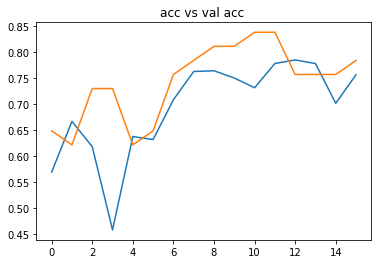

In [28]:
import matplotlib.pyplot as plt
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'])

plt.title(("acc vs val acc "))
plt.show()

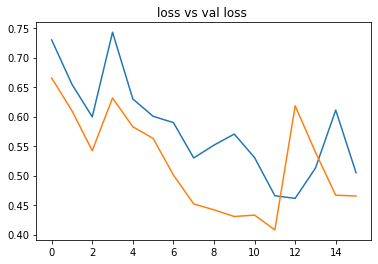

In [29]:
plt.plot(h['loss'])
plt.plot(h['val_loss'])

plt.title(("loss vs val loss "))
plt.show()

In [30]:
# Model accuracy 

from keras.models import load_model
model = load_model('/content/bestmodel.h5')

In [31]:
acc = model.evaluate_generator(test_data)[1]

print("The accuracy of model is:",acc*100, '%' )

The accuracy of model is: 78.37837934494019 %


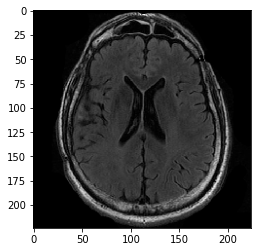

[[0.5118768]]
[[1.]]
The image contains brain tumor.


In [32]:
from keras.preprocessing.image import load_img , img_to_array

path = "/content/train/no/7 no.jpg"

img = load_img(path, target_size= (224,224))

input_arr =  img_to_array(img)/255
input_arr.shape
plt.imshow(input_arr)
plt.show()


input_arr = np.expand_dims(input_arr, axis=0)

pred = model.predict(input_arr)
print(pred)
pred=np.round(pred)
print(pred)
if pred == 1:
  print("The image contains brain tumor.")
else:
  print("The image doesn't contain brain tumor")



# Transfer Learning

In [34]:
from keras.layers import Flatten, Dense

In [38]:
from keras.models import Model, load_model
from keras.applications.mobilenet import MobileNet, preprocess_input